In [44]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import skimage.io as skio
import seaborn as sns 
from scipy.linalg import svd

**Preparing training and test set**

The dataset is divided into training and test set. The original dataset has 10 images of 40 people = 400 images.. The function below prepares  test set by keeping one image per person in the test set  = 40 and the remaining images (360) are retained in the training set.

In [45]:
def load_train_test_set():
    faces  = np.load('olivetti_faces.npy')
    target = np.load('olivetti_faces_target.npy')
    print("Original faces.shape:"+ str(faces.shape))
    print("Original target.shape:"+ str(target.shape))

    # create a test set that takes one face for each person
    test_index = list(range(9,400,10))
    faces_test = faces[test_index]
    target_test = target[test_index]

    # preprare training set by removing items in test set
    faces_train = faces.copy()
    target_train =  target.copy()
    for i in test_index[::-1]:
        faces_train  = np.delete(faces_train,i,axis =0 )
        target_train = np.delete(target_train,i,axis =0 )

    print("faces_train.shape:" +str(faces_train.shape))
    print("target_train.shape:" +str(target_train.shape))
    print("faces_test.shape:" +str(faces_test.shape))
    print("target_test.shape:" +str(target_test.shape))
    return faces_train, target_train, faces_test, target_test


In [46]:
faces_train, target_train, faces_test, target_test = load_train_test_set()

Original faces.shape:(400, 64, 64)
Original target.shape:(400,)
faces_train.shape:(360, 64, 64)
target_train.shape:(360,)
faces_test.shape:(40, 64, 64)
target_test.shape:(40,)


**Pre-process data**

In [47]:
def preprocess_data( faces_train, faces_test ):
    # flatten the imagaes from
    X_train =  np.reshape(faces_train,(faces_train.shape[0], -1 ))
    X_test =   np.reshape(faces_test, (faces_test.shape[0], -1 ))
    mu = np.mean(X_train, axis = 0 )
    std_dev = np.std(X_train, axis = 0) #this was wrongly given as np.mean 
    std_dev_mod = np.copy(std_dev)
    std_dev_mod[std_dev == 0 ] = 1 #dividing by 0 not possible
    X_train = (X_train - mu)/std_dev_mod
    # normalize the test set with same mu and std values as training set  --> IMPORTANT: SAME MU and STD as the TRAINING SET 
    X_test = (X_test - mu)/std_dev_mod
    return X_train, X_test


In [48]:
X_train, X_test = preprocess_data(faces_train, faces_test )
print("X_train.shape=" + str(X_train.shape))
print("X_test.shape="  + str(X_test.shape))

X_train.shape=(360, 4096)
X_test.shape=(40, 4096)


In [49]:
def show_images( images, num_images_to_show ):
    fig = plt.figure()
    for i in range(1,num_images_to_show+1):
        fig.add_subplot(1,num_images_to_show,i)
        img = np.reshape( images[:,i-1], (64,64) )
        plt.axis('off')
        plt.imshow(img, cmap='gray')

**Principle Component Analysis**

In [50]:
class PCA:
    def __init__( self, optimize = False ):
        self.__optimize = optimize

    def __calculate_covariance_matrix( self, X ):
        if self.__optimize: 
            return X @ X.T
        else:
            return X.T @ X

    def __get_eigenvecs_sorted_by_eigenvals( self, S ):
        w, v = np.linalg.eig(S)
        sorted_index = np.argsort(w)[::-1]
        eigenvals = w[sorted_index]
        eigenvecs = v[:,sorted_index]
        return eigenvals, eigenvecs

    def __get_eigenvec_for_original_matrix(  self, X, eigenvecs ):
        U = X.T @ eigenvecs 
        return U

    def fit( self, X ):
        S = self.__calculate_covariance_matrix( X )
        eigenvals,eigenvecs =   self.__get_eigenvecs_sorted_by_eigenvals( S )
        if self.__optimize :
            B = self.__get_eigenvec_for_original_matrix(X, eigenvecs )
        else:
            B = eigenvecs

        self.__B = B
        self.__w = eigenvals
        return B

    def plot_eigenvals ( self ):
        c = np.cumsum ( self.__w ) 
        plt.plot( c )

    def get_num_components ( self, variance_threshold):
        variance_ratio = self.__w/np.sum(self.__w)
        s = 0
        i = -1
        while s < variance_threshold and s < 1.0:
            i += 1
            s +=  variance_ratio[i]

        return i

62


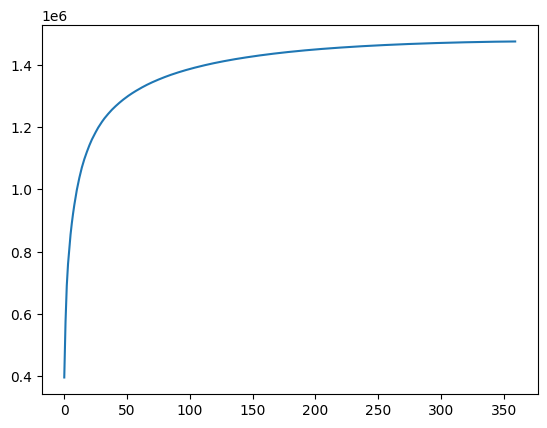

In [51]:
# Now since number of dimensions (D=4096 ) >> number of training samples (N = 360) , we calculate NXN covariance matrix instead of D X D
pca = PCA( optimize = True )
B = pca.fit(X_train)
pca.plot_eigenvals()
num_dim = pca.get_num_components(0.9)
print( num_dim )
B = B[:,:num_dim]

In [52]:
class Projection:
    def __init__( self, B ):
        self.B = B

    def reduce_dim( self, X ):
        return  X @ self.B @ np.linalg.inv(self.B.T @ self.B)  # @ means matrix multiplication

    def reconstruct( self, X_reduced ):
        return X_reduced @ self.B.T

    def get_projection_matrix( self ):
        P = self.B @ np.linalg.inv(self.B.T @ self.B) @ self.B.T
        return P

    def project( self , X ):
        P = self.get_projection_matrix()
        return X @ P

In [53]:
proj = Projection( B )
print(f'X_train shape before projection = {X_train.shape}')
X_train_reduced = proj.reduce_dim(X_train)
print("X_train_reduced.shape="+str(X_train_reduced.shape) ) #This is in the eigenvector dimensions 
X_test_reduced =proj.reduce_dim(X_test)
print("X_test_reduced.shape="+str(X_test_reduced.shape))

X_train shape before projection = (360, 4096)
X_train_reduced.shape=(360, 62)
X_test_reduced.shape=(40, 62)


**Image Recognition**

PCA can be used for face recognition. The idea is to :
1. Reduce dimensions of the face image to be recognized
2. Compare it with the mean image of face class class, where a class here maps to mean of images of a singleperson
3. The class to which the euclidean distance is the smallest is the class to which the person belongs i.e. is the face image of the person belonging to that class

In [54]:
class ImageClassifier:
    def __init__( self, class_count ):
        self.class_count = class_count

    def __get_class_mean( self, X, target ):
        class_count = self.class_count
        N,D = X.shape
        mu = np.zeros((class_count,D)) #vector to store mean image of each class
        for i in range(class_count):
            mu[i,:] = (1/N) * np.sum(X[target == i,: ], axis = 0 )
        return mu

    def __dist(self, v1, v2 ):
        diff = v1-v2
        d = np.sqrt(np.dot(diff,diff))
        return d

    def fit( self,  X, target  ):
        class_count = self.class_count
        mu = self.__get_class_mean( X, target ) #fit is basically just storing the mean images of each class
        self.mu = mu

    def predict( self, test_img ):
        min_dist = np.inf
        min_class = -1
        for i in range( self.class_count ):
            d = self.__dist(test_img, self.mu[i,:]) # "fitness" to the i-th class is the euclidean distance from the mean image of the ith class 
            if d < min_dist:
                min_dist = d
                min_class = i

        return min_class, self.mu[min_class,:]

In [55]:
img_classifer = ImageClassifier(40)
img_classifer.fit(X_train_reduced,target_train )

In [56]:
result_classes = np.zeros(X_test_reduced.shape[0])

for i in range(len(result_classes)):
    rec_class, _ = img_classifer.predict(X_test_reduced[i,:])
    result_classes[i] = rec_class

**Qn 1: Calculate the performance on the Test dataset (in percentage).**

In [65]:
result_classes = np.zeros(X_test_reduced.shape[0])
n_correct = 0
for i in range(len(result_classes)):
    rec_class, _ = img_classifer.predict(X_test_reduced[i,:])
    if rec_class == target_test[i]:
        n_correct = n_correct + 1

print(f'Accuracy = {(n_correct/len(target_test))*100} %')

Accuracy = 92.5 %


**Qn 2: Repeat the face regognition with extracting the eigenvectors that capture (a) 80% of the variance (b) 50% of the variance. Provide sample results and the performance accuracy.**


In [58]:
class Model:
    def __init__(self, variance_thresh):
        self.variance_thresh = variance_thresh
        self.classifier = ImageClassifier(40)
        self.pca = PCA(optimize=True)

    def train(self, X_train, target_train):
        self.__find_projection(X_train)
        X_train_red = self.__get_reduced(X_train)
        self.classifier.fit(X_train_red, target_train)

    def report_accuracy(self, X_test, target_test):
        classifier = self.classifier
        X_test_red = self.__get_reduced(X_test)
        correct = 0
        for i in range(len(target_test)):
            pred_class, _ = classifier.predict(X_test_red[i,:])
            if pred_class == target_test[i]:
                correct = correct + 1
        print(f'Accuracy = {(correct/len(target_test))*100} %')
    
    def predict(self, test_img):
        test_img_reduced = self.__get_reduced(test_img)
        classifier = self.classifier
        pred_class, _ = classifier.predict(test_img_reduced)
        return pred_class

    def __get_half_image(self, test_index, X_test):
        orig_image = np.copy(X_test[test_index,:])
        D, = orig_image.shape
        orig_image = np.reshape(orig_image, (1,D))
        half_image = np.copy(orig_image)
        half_image[0, 2048: 4096] = 0
        return half_image, orig_image

    def reconstruct(self, test_indices, X_test):
        for i in test_indices:
            print(f"Test index {i}")
            half_image, orig_image = self.__get_half_image(i, X_test)
            N,D = half_image.shape
            new_image = self.proj.project(half_image)
            new_img_with_orig_half = np.copy(new_image)
            new_img_with_orig_half[0,0:2048] = orig_image[0, 0:2048]
            images_for_display = np.concatenate((orig_image.T, half_image.T, new_image.T, new_img_with_orig_half.T), axis=1 )
            show_images(images_for_display, 4)


    def __get_B(self, X_train):
        variance_thresh = self.variance_thresh
        print(f'Variance limit = {variance_thresh}')
        # pca1 = PCA(optimize=True)
        B = self.pca.fit(X_train)
        num_dim = self.pca.get_num_components(variance_thresh)
        print(f"Number of dimensions: {num_dim}")
        B = B[:, :num_dim]
        self.B = B 
        return B

    def __find_projection(self,X_train):
        B = self.__get_B(X_train)
        self.proj = Projection(B)
    
    def __get_reduced(self, X):
        return self.proj.reduce_dim(X)


In [59]:
# 50% variance
model = Model(0.5)
model.train(X_train, target_train)
model.report_accuracy(X_test, target_test)

Variance limit = 0.5
Number of dimensions: 3
Accuracy = 30.0 %


(-0.5, 63.5, 63.5, -0.5)

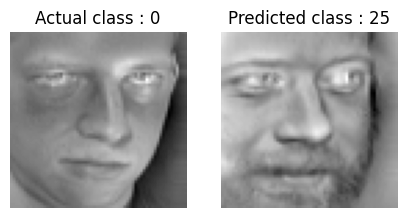

In [79]:
#Sample result for 50 % variance 
test_img = X_test[0, :]
fig, ax = plt.subplots(1,2, figsize=(5,5), squeeze=False)
act_class = target_test[0]
pred_class = model.predict(test_img)
pred_img = X_test[pred_class, :]
ax[0][0].imshow(np.reshape(test_img, (64,64)), cmap='gray')
ax[0][0].set_title(f"Actual class : {act_class}")
ax[0][0].axis('off')
ax[0][1].imshow(np.reshape(pred_img, (64,64)), cmap = 'gray')
ax[0][1].set_title(f"Predicted class : {pred_class}")
ax[0][1].axis('off')

In [60]:
# 80% variance
model1 = Model(0.8)
model1.train(X_train, target_train)
model1.report_accuracy(X_test, target_test)

Variance limit = 0.8
Number of dimensions: 25
Accuracy = 90.0 %


(-0.5, 63.5, 63.5, -0.5)

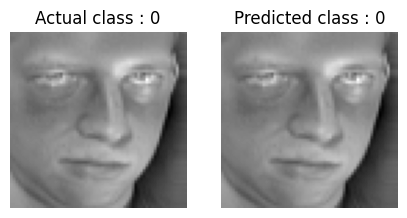

In [80]:
#Sample result for 80 % variance 
test_img = X_test[0, :]
fig, ax = plt.subplots(1,2, figsize=(5,5), squeeze=False)
act_class = target_test[0]
pred_class = model1.predict(test_img)
pred_img = X_test[pred_class, :]
ax[0][0].imshow(np.reshape(test_img, (64,64)), cmap='gray')
ax[0][0].set_title(f"Actual class : {act_class}")
ax[0][0].axis('off')
ax[0][1].imshow(np.reshape(pred_img, (64,64)), cmap = 'gray')
ax[0][1].set_title(f"Predicted class : {pred_class}")
ax[0][1].axis('off')

**Reconstructing incomplete image**

**Qn 3: Repeat the face reconstruction with extracting the eigenvectors that capture (a) 80% of the variance (b) 50% of the variance. Provide sample results.**

Variance limit = 0.8
Number of dimensions: 25
Test index 0
Test index 10
Test index 30


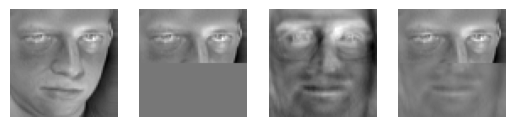

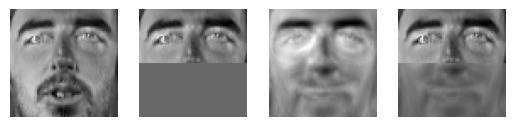

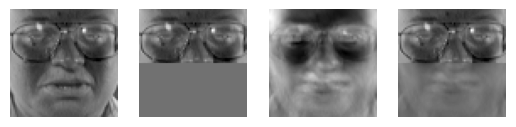

In [61]:
# (a) 80 % variance 
model_80 = Model(0.8)
model_80.train(X_train, target_train)
model_80.reconstruct([0,10,30], X_test)

We can see below that if we take only 50% of the eigenvalues, we miss a lot of defining features and in general, the projection is inaccurate

Variance limit = 0.5
Number of dimensions: 3
Test index 0
Test index 10
Test index 30


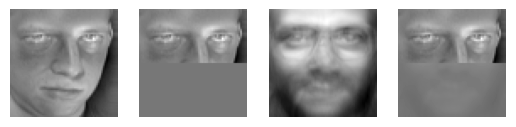

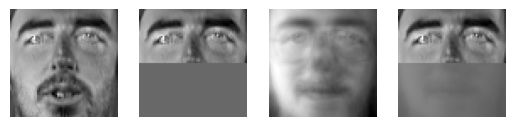

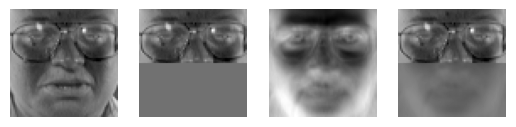

In [62]:
# (b) 50 % variance limit
model_50 = Model(0.5)
model_50.train(X_train, target_train)
model_50.reconstruct([0,10,30], X_test)

**Singular Value Decomposition**

data.shape=(4096, 360)


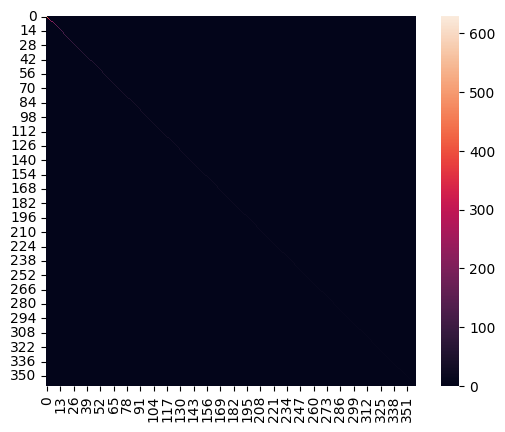

In [63]:
data = X_train.T

plt.imshow(data, cmap='gray')
print("data.shape=" + str(data.shape))
U, S, V_T = svd(data, full_matrices=False)
S = np.diag(S)
sns.heatmap(S)
plt.show()

**Q4. Add Random noise to the data and compare these results with the no noise case above. (you may uncomment the noise addition part in the code)**

**Q5. Use standard deviation of noise as 0.05, 0.1, and 0.2**


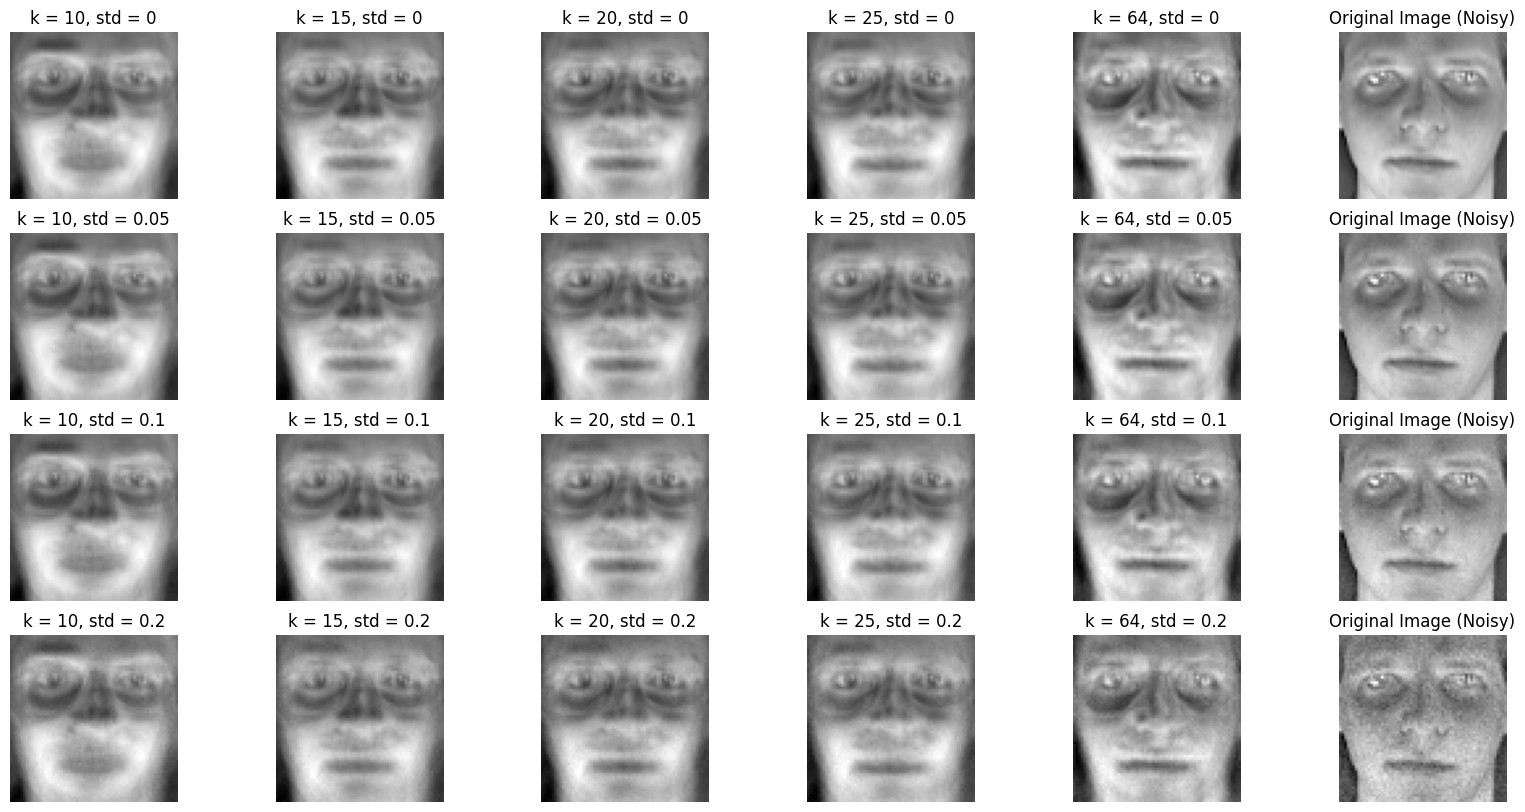

In [64]:
img_idx = 0
data = X_train.T
noise_std_list = [0, 0.05, 0.1, 0.2] #std = 0  is the no noise case
n_sv_list = [10, 15, 20, 25, 64]
fig, ax = plt.subplots(len(noise_std_list), len(n_sv_list)+1, figsize=(20, 10))
curr_fig = 0

for noise_std in noise_std_list:
    
    #Adding noise to data
    noise = np.random.normal(0, noise_std, data.shape)
    noisy_data = data + noise

    #Computing svd
    U, S, V_T = svd(noisy_data, full_matrices=False)
    S = np.diag(S)

    #Showing images 
    i=0
    for r in n_sv_list:
        data_approx = U[:, :r] @ S[0:r, :r] @ V_T[:r, :]
        img = np.reshape(data_approx[:,img_idx], (64,64))
        ax[curr_fig][i].imshow(img, cmap='gray')
        ax[curr_fig][i].set_title(f"k = {r}, std = {noise_std}")
        ax[curr_fig][i].axis('off')
        i=i+1
    
    img_orig = np.reshape( noisy_data[:,img_idx], (64,64) )
    ax[curr_fig][i].imshow(img_orig, cmap='gray')
    ax[curr_fig][i].set_title("Original Image (Noisy)")
    ax[curr_fig][i].axis('off')
    
    curr_fig += 1

plt.show()